# CSGY 6923 Machine Learning - Fine tuning BERT for Question Answering

Install necessary dependencies

In [1]:
!pip install datasets torch transformers[torch] matplotlib seaborn

## Import necessary modules.

We use the `datasets` and `transformers` HuggingFace libraries

In [26]:
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer, DefaultDataCollator
import torch
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

## Connecting Google Drive to persist model weights

## Dataset.

The `SQuAD` dataset (Standard Question and Answering Dataset) is the dataset of choice for this fune tuning task

In [3]:
squad = load_dataset("squad", split="train[:5000]")
squad = squad.train_test_split(test_size=0.2)

Coverting the dataset into a dictionary

In [4]:
data_dict = squad["train"].to_dict()

df = pd.DataFrame.from_dict(data_dict)

In [5]:
df.head()

,id,title,context,question,answers
0,56d0007f234ae51400d9c244,Solar_energy,Solar distillation can be used to make saline ...,By who was the first record of solar distillat...,"{'text': ['16th-century Arab alchemists'], 'an..."
1,56d007a6234ae51400d9c2a9,New_York_City,The iconic New York City Subway system is the ...,Which station is known as the world's biggest ...,"{'text': ['Grand Central Station'], 'answer_st..."
2,573393e1d058e614000b5dc5,University_of_Notre_Dame,Hesburgh is also credited with transforming th...,What title did Thomas Blantz have at Notre Dame?,{'text': ['Vice President of Student Affairs']...
3,56cdb27562d2951400fa6812,Spectre_(2015_film),The story sees Bond pitted against the global ...,What group is the enemy of the protagonist?,"{'text': ['Spectre'], 'answer_start': [68]}"
4,56d45abf2ccc5a1400d830e5,Beyoncé,"At age eight, Beyoncé and childhood friend Kel...",How old was Beyoncé when she met LaTavia Rober...,"{'text': ['eight'], 'answer_start': [7]}"


We see that the dataset has multiple columns that determine the context and the position of the answer within the question

In [6]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

questions = [q.strip() for q in df["question"]]
context = [q.strip() for q in df["context"]]
inputs = tokenizer(
        questions,
        context,
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

In [7]:
offset_mapping = inputs.pop("offset_mapping")

start_positions = []
end_positions = []
answers = df['answers']
for i, offset in enumerate(offset_mapping):
    answer = answers[i]
    start_char = answer["answer_start"][0]
    end_char = answer["answer_start"][0] + len(answer["text"][0])
    sequence_ids = inputs.sequence_ids(i)

    # Find the start and end of the context
    idx = 0
    while sequence_ids[idx] != 1:
        idx += 1
    context_start = idx
    while sequence_ids[idx] == 1:
        idx += 1
    context_end = idx - 1

    # If the answer is not fully inside the context, label it (0, 0)
    if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
        start_positions.append(0)
        end_positions.append(0)
    else:
        # Otherwise it's the start and end token positions
        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)

df["start_positions"] = start_positions
df["end_positions"] = end_positions

data = {'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'start_positions':start_positions,
        'end_positions': end_positions,
       }

Creating a Dataset from the augmented dataframe

In [8]:
df = pd.DataFrame(data)
df.to_csv('encoding_train.csv',index=False)
train = Dataset.from_pandas(df)

Doing the same preprocessing on the test dataset.

In [9]:
data_dict = squad["test"].to_dict()
# Create a DataFrame from the dictionary
df = pd.DataFrame.from_dict(data_dict)

questions = [q.strip() for q in df["question"]]
context = [q.strip() for q in df["context"]]
inputs = tokenizer(
        questions,
        context,
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

offset_mapping = inputs.pop("offset_mapping")

start_positions = []
end_positions = []
answers = df['answers']
for i, offset in enumerate(offset_mapping):
    answer = answers[i]
    start_char = answer["answer_start"][0]
    end_char = answer["answer_start"][0] + len(answer["text"][0])
    sequence_ids = inputs.sequence_ids(i)

    # Find the start and end of the context
    idx = 0
    while sequence_ids[idx] != 1:
        idx += 1
    context_start = idx
    while sequence_ids[idx] == 1:
        idx += 1
    context_end = idx - 1

    # If the answer is not fully inside the context, label it (0, 0)
    if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
        start_positions.append(0)
        end_positions.append(0)
    else:
        # Otherwise it's the start and end token positions
        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)

df["start_positions"] = start_positions
df["end_positions"] = end_positions

data = {'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'start_positions':start_positions,
        'end_positions': end_positions,
       }
df = pd.DataFrame(data)
df.to_csv('encoding_test.csv',index=False)
test = Dataset.from_pandas(df)

## Training the model

In [10]:
data_collator = DefaultDataCollator()
model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-uncased")

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
training_args = TrainingArguments(
    output_dir="./bert-qna",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
)

/usr/local/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

/tmp/ipykernel_165/1206778530.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [13]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,2.623099
2,2.869200,1.863151
3,2.869200,1.712226


TrainOutput(global_step=750, training_loss=2.4060270589192707, metrics={'train_runtime': 103.8935, 'train_samples_per_second': 115.503, 'train_steps_per_second': 7.219, 'total_flos': 1175877900288000.0, 'train_loss': 2.4060270589192707, 'epoch': 3.0})

## Model Inference - Question Answering

Load the model into memory

In [14]:
MODEL_PATH = "./bert-qna/checkpoint-750"
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForQuestionAnswering.from_pretrained(MODEL_PATH)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Setting the model to evaluation mode

In [15]:
model.eval()

DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
     

Create a `BertQuestionAnswering` helper class to visualize inference

In [21]:
class BERTQuestionAnswering:
    def __init__(self, model_path):
        self.tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
        self.model = AutoModelForQuestionAnswering.from_pretrained(model_path)
        self.model.eval()
        
    def answer_question(self, question, context, display_attention=False):
        # Tokenize input
        inputs = self.tokenizer(
            question,
            context,
            add_special_tokens=True,
            return_tensors="pt",
            max_length=384,
            truncation="only_second",
            padding="max_length"
        )
        
        # Get model predictions
        with torch.no_grad():
            outputs = self.model(**inputs)
            
        # Get start and end positions
        start_scores = outputs.start_logits.softmax(dim=-1)
        end_scores = outputs.end_logits.softmax(dim=-1)
        
        # Find the most likely answer span
        start_idx = torch.argmax(start_scores)
        end_idx = torch.argmax(end_scores)
        
        # Convert tokens to answer text
        answer_tokens = inputs.input_ids[0][start_idx:end_idx + 1]
        answer_text = self.tokenizer.decode(answer_tokens)
        
        # Calculate confidence score
        confidence = float(start_scores[0][start_idx] * end_scores[0][end_idx])
        
        return {
            "answer": answer_text,
            "confidence": confidence,
            "start_idx": start_idx.item(),
            "end_idx": end_idx.item(),
            "token_scores": {
                "start": start_scores[0].tolist(),
                "end": end_scores[0].tolist()
            }
        }
    
    def visualize_answer(self, question, context, result, save_html=False, filename=None):
        # Create HTML for highlighted answer
        context_words = context.split()
        answer_words = result["answer"].split()
        
        highlighted_context = []
        for i, word in enumerate(context_words):
            if any(answer_word in word for answer_word in answer_words):
                highlighted_context.append(f'<span style="background-color: #FFE599; font-weight: bold;">{word}</span>')
            else:
                highlighted_context.append(word)
        
        html = f"""
        <div style="font-family: Arial; padding: 20px; border: 1px solid #ddd; border-radius: 5px; margin: 10px 0;">
            <div style="font-size: 18px; color: #2F5496; margin-bottom: 10px;">
                <strong>Question:</strong> {question}
            </div>
            <div style="font-size: 16px; margin-bottom: 15px;">
                <strong>Context:</strong> {' '.join(highlighted_context)}
            </div>
            <div style="font-size: 18px; color: #2F5496;">
                <strong>Answer:</strong> {result["answer"]} 
                <span style="color: #666; font-size: 14px;">(Confidence: {result["confidence"]:.2%})</span>
            </div>
        </div>
        """
        
        display(HTML(html))
        if save_html:
            if filename is None:
                timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                filename = f'qa_result_{timestamp}.html'
            
            with open(filename, 'w', encoding='utf-8') as f:
                f.write(html)
            print(f"HTML visualization saved to {filename}")
    
    def plot_token_scores(self, question, context, result, save_path=None):
        # Tokenize the input to get token mappings
        tokens = self.tokenizer.tokenize(question + " " + context)
        
        # Create score visualization
        plt.figure(figsize=(15, 5))
        
        # Plot start scores
        plt.subplot(1, 2, 1)
        sns.barplot(x=range(len(tokens[:20])), y=result["token_scores"]["start"][:20])
        plt.title("Start Position Scores")
        plt.xticks(range(len(tokens[:20])), tokens[:20], rotation=45, ha='right')
        
        # Plot end scores
        plt.subplot(1, 2, 2)
        sns.barplot(x=range(len(tokens[:20])), y=result["token_scores"]["end"][:20])
        plt.title("End Position Scores")
        plt.xticks(range(len(tokens[:20])), tokens[:20], rotation=45, ha='right')
        
        plt.tight_layout()
        
        # Save the plot if a path is provided
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
            print(f"Plot saved to {save_path}")
        
        plt.show()

Helper function to asnwer questions

In [23]:
def answer_questions():
    # Initialize the QA system
    qa_system = BERTQuestionAnswering(model_path=MODEL_PATH)
    
    # Example 1: Historical fact
    context1 = """The Apollo 11 spacecraft landed on the Moon on July 20, 1969. 
                  Neil Armstrong became the first human to step onto the lunar surface, 
                  followed by Buzz Aldrin. They spent about two and a half hours exploring 
                  and collecting samples."""
    question1 = "Who was the first person to walk on the Moon?"
    
    # Example 2: Scientific explanation
    context2 = """Photosynthesis is the process by which plants convert light energy 
                  into chemical energy. This process occurs in the chloroplasts, 
                  specifically using chlorophyll pigments. The end products are 
                  glucose and oxygen, while carbon dioxide and water are the raw materials."""
    question2 = "What are the end products of photosynthesis?"
    
    # Example 3: Complex reasoning
    context3 = """The Industrial Revolution began in Britain in the late 18th century. 
                  It brought about major changes in agriculture, manufacturing, mining, 
                  and transport. While it led to economic growth and technological progress, 
                  it also caused environmental pollution and poor working conditions for many laborers."""
    question3 = "What were the negative effects of the Industrial Revolution?"
    
    # Process each example
    examples = [
        (question1, context1),
        (question2, context2),
        (question3, context3)
    ]
    
    for question, context in examples:
        print("\n" + "="*80 + "\n")
        result = qa_system.answer_question(question, context)
        qa_system.visualize_answer(question, context, result, save_html=True)
        qa_system.plot_token_scores(question, context, result, save_path="./plots.png")

HTML visualization saved to qa_result_20241210_062451.html
Plot saved to ./plots.png


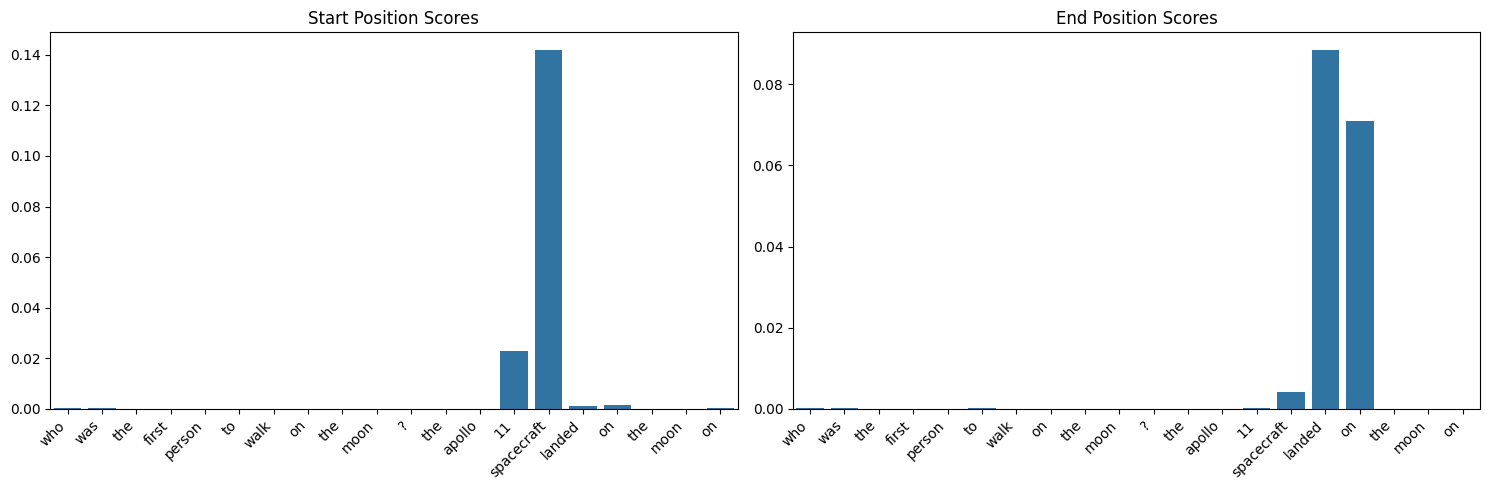

HTML visualization saved to qa_result_20241210_062452.html
Plot saved to ./plots.png


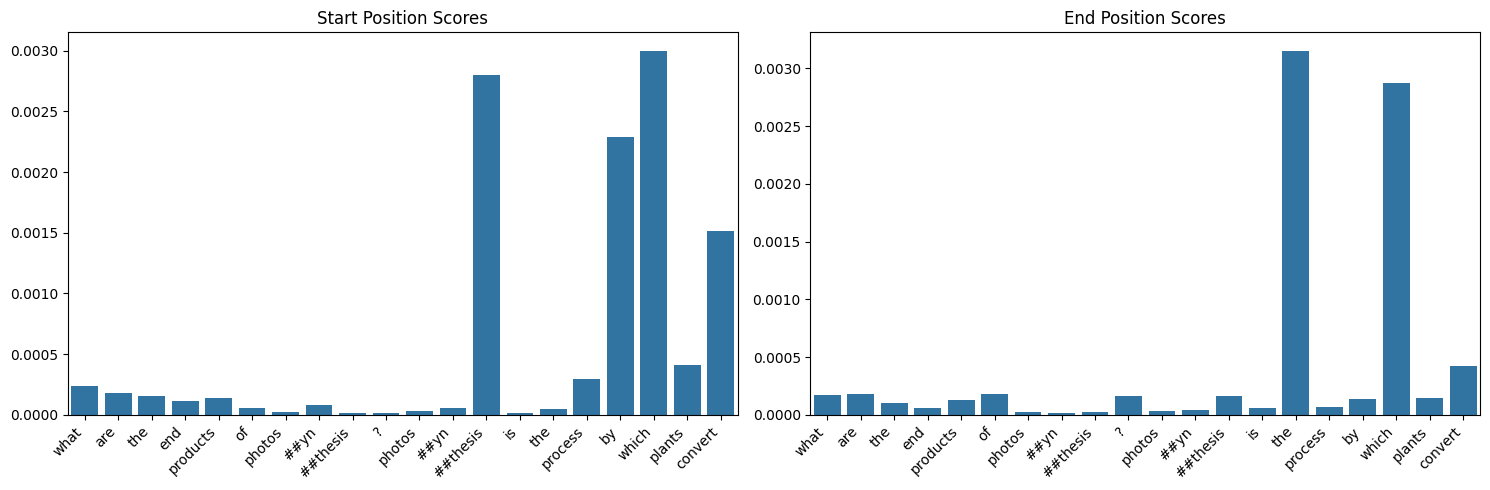

HTML visualization saved to qa_result_20241210_062453.html
Plot saved to ./plots.png


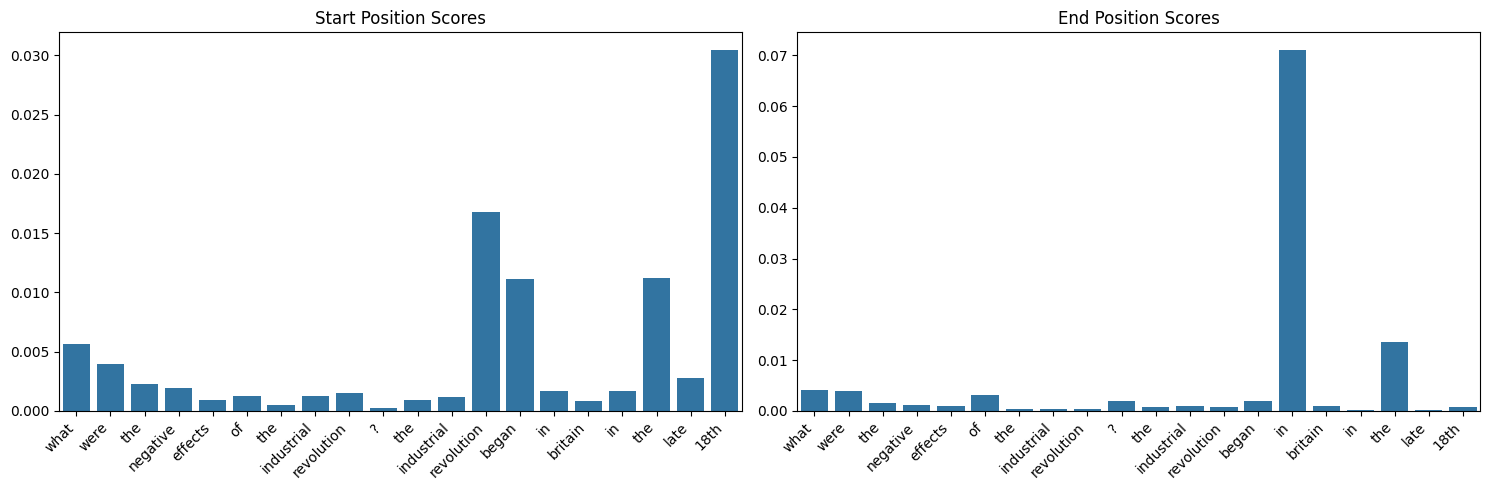

In [27]:
answer_questions()